In [18]:
!pip install qiskit qiskit-aer matplotlib


 Enter the Noise Model Parameters: 
 Please note that even though the range for time values maybe suggested in nanosec, please enter the values in microseconds
Enter the Depolarizing probability value(1-10 % for hBN, enter as 0.01): 0.04
Enter T1 Relaxation Time (10-20 microseconds for hBN ): 12
Enter T2 Relaxation Time (50–100 ns for hBN)(t2 should not be >2*t1:0.07
Enter Gate Time (10-100 ns fro hBN): 0.03

--- The input parameters for noise model are: ---
Depolarizing Probability is (1-10 %, enter as 0.01): 0.04
Enter T1 Relaxation Time (10-20 microseconds for hBN ): 12.0
Enter T2 Relaxation Time (50–100 ns for hBN): 0.07
Measurement Gate Time (10-100 ns fro hBN): 0.03
----------------------------------



/tmp/ipython-input-1738565201.py:130: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(steps, angles, 's-', alpha=0.5, label="Applied rotation (θ) in radians ", color='darkblue', markersize=4, linestyle='--')


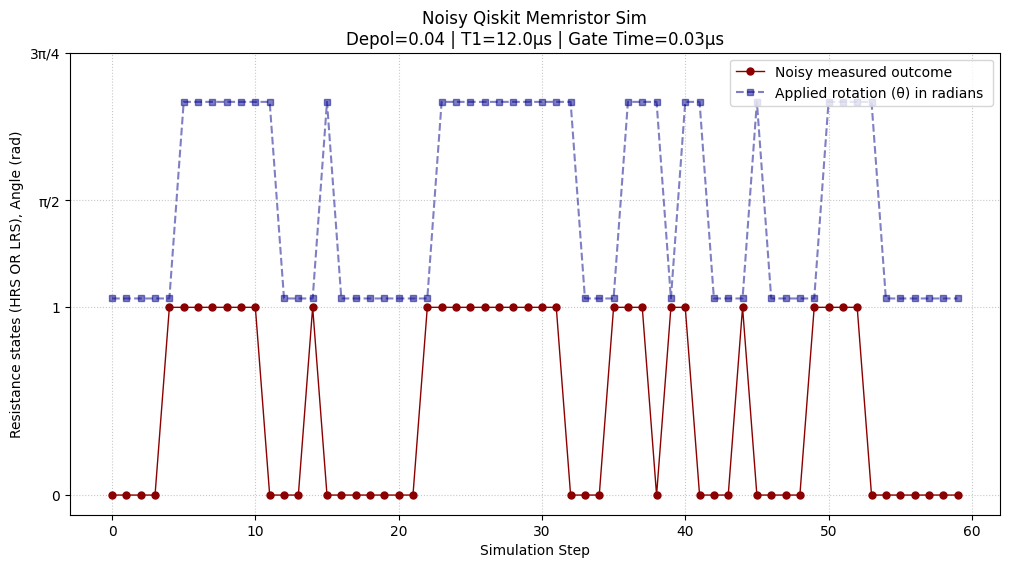

In [26]:
# This is a simulation of a noisy memristor based on material specific values of hBN taken from literature.

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
import matplotlib.pyplot as plt # need it to display output as a plot
import numpy as np
import math # need it to do the math of rotation

#  quantum circuit for memristor sim
def memristor_circuit(theta):
    qc = QuantumCircuit(1, 1)
    qc.ry(theta, 0)
    qc.measure(0, 0)
    return qc

# Noise model that is dependent on user input values
def qc_noisemodel(depolarizing_prob, t1, t2, gate_time):

    noise_model = NoiseModel()

    # depolarizign error is to be added at every step
    derror = depolarizing_error(depolarizing_prob, 1)
    noise_model.add_all_qubit_quantum_error(derror, ['ry'])

    # Thermal relaxation error is to be added at every step
    terror = thermal_relaxation_error(t1, t2, gate_time)# t1, t2, gate time are in microseconds
    noise_model.add_all_qubit_quantum_error(terror, ['measure'])

    print("\n--- The input parameters for noise model are: ---")
    print(f"Depolarizing Probability is (1-10 %, enter as 0.01): {depolarizing_prob}")
    print(f"Enter T1 Relaxation Time (10-20 microseconds for hBN ): {t1}")
    print(f"Enter T2 Relaxation Time (50–100 ns for hBN): {t2}")
    print(f"Measurement Gate Time (10-100 ns fro hBN): {gate_time}")
    print("----------------------------------\n")

    return noise_model

# noise model simulation
def noisy_qc_sim(steps=60, **noise_params):


    noise_model =  qc_noisemodel(**noise_params)
    backend = AerSimulator(noise_model=noise_model)

    state = 0
    history = []
    # considering tht probability for ry gate is given bt P(1) = sin^2(θ/2)
    low_angle = math.pi / 3
    high_angle =  2* math.pi /3


   # simulation
    for step in range(steps):

        theta = low_angle  if state == 0 else high_angle # theta would be set by previous measurement just like a memristor!!
        qc = memristor_circuit(theta)
        result = backend.run(qc, shots=1).result()

        outcome = int(list(result.get_counts().keys())[0])# to get 0 or 1 corresponding to LHS n RHS

        state = outcome # update the current state based on prev one
        history.append((step, outcome, theta))

    return history

# input the parameters and plot the outcome

def get_user_noise_parameters():

    print(" Enter the Noise Model Parameters: ")
    print(" Please note that even though the range for time values maybe suggested in nanosec, please enter the values in microseconds")

    while True:
        try:
            d_prob = float(input("Enter the Depolarizing probability value(1-10 % for hBN, enter as 0.01): "))
            if not (0 <= d_prob <= 1):
                raise ValueError("Probability must be between 0 and 1")
            break
        except ValueError as e:
            print(f"The input seems to be invalid: {e} please try a different value")

    while True:
        try:
            t1 = float(input("Enter T1 Relaxation Time (10-20 microseconds for hBN ): "))
            if t1 <= 0:
                raise ValueError("T1 time must be positive.")
            break
        except ValueError as e:
            print(f"The input seems to be invalid: {e} please try a different value")

    while True:
        try:
            t2 = float(input("Enter T2 Relaxation Time (50–100 ns for hBN)(t2 should not be >2*t1:"))
            if t2 <= 0:
                raise ValueError("T2 time must be positive.")
            break
        except ValueError as e:
            print(f"The input seems to be invalid: {e} please try a different value")

    while True:
        try:
            gate_time = float(input("Enter Gate Time (10-100 ns fro hBN): "))
            if gate_time <= 0:
                raise ValueError("Gate time must be positive.")
            break
        except ValueError as e:
            print(f"The input seems to be invalid: {e} please try a different value")

    return {
        'depolarizing_prob': d_prob,
        't1': t1,
        't2': t2,
        'gate_time': gate_time
    }

# get parameters from the user
noise_params = get_user_noise_parameters()
sim_steps = 60

# execute the simulation
data = noisy_qc_sim( steps=sim_steps, **noise_params)
# plotting
steps, outcomes, angles = zip(*data)


plt.figure(figsize=(12, 6))
plt.plot(steps, outcomes, 'o-', label="Noisy measured outcome", color='darkred', markersize=5, linewidth=1)
plt.plot(steps, angles, 's-', alpha=0.5, label="Applied rotation (θ) in radians ", color='darkblue', markersize=4, linestyle='--')
plt.xlabel("Simulation Step")
plt.ylabel("Resistance states (HRS OR LRS), Angle (rad)")
plt.legend(loc='upper right')
plt.title(f"Noisy qiskit memristor sim\nDepol={noise_params['depolarizing_prob']} | T1={noise_params['t1']}μs | Gate time={noise_params['gate_time']}μs")
plt.yticks([0, 1, math.pi / 2, 3* math.pi / 4], ['0', '1', 'π/2', '3π/4'])
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()